##### Copyright 2022 The Cirq Developers

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QVM Basic Example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/simulate/qvm_basic_example"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/simulate/qvm_basic_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/simulate/qvm_basic_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/simulate/qvm_basic_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook walks through running a simple circuit on the [Quantum Virtual Machine](/cirq/simulate/quantum_virtual_machine), including the necessary constraints on a device-runnable circuit and how to satisfy them. 

## **Install** Cirq and qsim

In [ ]:
# @title Install `cirq_google` and `qsimcirq`

try:
    import cirq
    import cirq_google
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq-google
    print("installed cirq.")
    import cirq
    import cirq_google

try:
    import qsimcirq
except ImportError:
    print("installing qsimcirq...")
    !pip install --quiet qsimcirq
    print(f"installed qsimcirq.")
    import qsimcirq

# Other modules used in this colab
import matplotlib.pyplot as plt
import time

## Create a **Quantum Virtual Machine**

The following cell builds a Quantum Virtual Machine that mimics a particular Google quantum hardware device (currently Rainbow or Weber) using the following customizable steps: 
- Constructing a `cirq.NoiseModel` object from device calibration data saved in Cirq. See [Representing Noise](/cirq/noise/representing_noise) for more on noise models. 
- Building a `qsimcirq.QsimSimulator` that uses this noise model. See [Noisy Simulation](/cirq/simulate/noisy_simulation) and [Noise simulation with qsim](/qsim/tutorials/noisy_qsimcirq) for more. 
- Creating a `cirq.Device` that imposes the same constraints on circuits that the original device would. See [Devices](/cirq/hardware/devices) for more on these constraint objects. 
- Packaging the simulator and device into an object that implements the `cirq.Engine` interface that the hardware device would use. 

If you don't need this level of control, you can also instantiate a QVM with `cirq_google.engine.create_default_noisy_quantum_virtual_machine`, as in [QVM Creation Template](/cirq/simulate/qvm_builder_code). 

In [ ]:
# @title Choose a processor ("rainbow" or "weber")
processor_id = "weber"  # @param {type:"string"}

# Construct a simulator with a noise model based on the specified processor.
cal = cirq_google.engine.load_median_device_calibration(processor_id)
noise_props = cirq_google.noise_properties_from_calibration(cal)
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
sim = qsimcirq.QSimSimulator(noise=noise_model)

# Create a device from the public device description
device = cirq_google.engine.create_device_from_processor_id(processor_id)
# Build the simulated local processor from the simulator and device.
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id, sampler=sim, device=device, calibrations={cal.timestamp // 1000: cal}
)
# Package the processor to use an Engine interface
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])
print(
    "Your quantum virtual machine",
    processor_id,
    "is ready, here is the qubit grid:",
    "\n========================\n",
)
print(sim_engine.get_processor(processor_id).get_device())

Your quantum virtual machine weber is ready, here is the qubit grid: 

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                                    (2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                                    │        │        │        │        │
                                    │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4,

## **Create** a circuit, **transform** it (to make it executable on Google quantum hardware) and **choose qubits** on the processor. 

The circuit you use needs to be _device ready_, which means it: 
- Is comprised of operations from the device's gate set. 
- Is applied to qubits that exist on the device. 
- Respects the connectivity of qubits on the device.

Below is an example of a circuit that has the correct topology to be placed on the Weber device, and how it is prepared to be run on the QVM.

### Create a GHZ state builder circuit

The generalized [Greenberger–Horne–Zeilinger (GHZ) state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state){:.external} has the form $\frac{|00..0⟩ + |11..1⟩}{\sqrt{2}}$ and, in this case, will be constructed using 17 qubits, with a Hadamard and a sequence of CNOT gates:

In [ ]:
from cirq.circuits.moment import Moment
from cirq.ops.swap_gates import SWAP
# Define an abstract line of 17 qubits
number_of_qubits = 17
qubits = cirq.LineQubit.range(number_of_qubits)

# Create a GHZ circuit on this qubit line
ghz_circuit = cirq.Circuit(
    cirq.H(qubits[0]),
    *[cirq.CNOT(qubits[i - 1], qubits[i]) for i in range(1, number_of_qubits)],
    cirq.measure(*qubits, key='out'),
)
# print(ghz_circuit)

# D4 multiplication

h_m, h_R2, h_R = [cirq.GridQubit(i,0) for i in range(3)]
g_m, g_R2, g_R = [cirq.GridQubit(i,1) for i in range(3)]

D_premult = cirq.Circuit()
D_premult.append([cirq.Moment(cirq.X(h_R)),
                  cirq.SWAP(h_R2,h_R),
                  cirq.TOFFOLI(h_R2,g_m,g_R2),
                  cirq.TOFFOLI(h_R2,g_R,g_R2),
                  cirq.SWAP(h_R2,h_R),
                  cirq.Moment(cirq.CNOT(h_m,g_m),
                              cirq.CNOT(h_R2,g_R2),
                              cirq.CNOT(h_R,g_R)),
                  cirq.measure(g_m,g_R,g_R2,key='out')

])

# print(D_premult)

control = cirq.NamedQubit('control')
target = cirq.NamedQubit('target')

CNOT_circuit = cirq.Circuit()
CNOT_circuit.append([cirq.X(control), cirq.CNOT(control,target),cirq.measure(target)])
print(CNOT_circuit)



control: ───X───@───────
                │
target: ────────X───M───


Notice that this circuit consists of a sequence of CNOT gates applied consecutively to a single chain of qubits. The connectivity required by the circuit is simple in the sense that it needs a line of qubits which are only connected to their adjacent neighbor in the sequence. As constructed, this consists of 17 `cirq.LineQubit`s indexed `0, 1, 2...16`. 

### Transform the circuit 

Before executing a circuit on (virtual) quantum hardware, the operations in the circuit need to be translated to use the types of gates the device supports. The `cirq.optimize_for_target_gateset` function does this for you, transforming the operations to use the `cirq.SqrtIswapTargetGateset`, which is supported by the Weber processor that this QVM is based on. Learn more about the gate set constraints of Google hardware at the [Hardware](/hardware) page.

In [ ]:
# Convert the gates in the GHZ circuit to the "SqrtIswap" gateset, which the device uses.
translated_ghz_circuit = cirq.optimize_for_target_gateset(
    ghz_circuit, context=cirq.TransformerContext(deep=True), gateset=cirq.SqrtIswapTargetGateset()
)
# print(translated_ghz_circuit)

translated_D_premult = cirq.optimize_for_target_gateset(
    D_premult, context=cirq.TransformerContext(deep=True), gateset=cirq_google.SycamoreTargetGateset()
)

translated_CNOT_circuit = cirq.optimize_for_target_gateset(
    CNOT_circuit, context=cirq.TransformerContext(deep=True), gateset=cirq_google.SycamoreTargetGateset()
)

print(translated_D_premult)

(0, 0): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Choose qubits on the virtual device

Choose qubits on the device to execute your device ready circuit on. Look at the device map (as above) and choose a set of qubits that fit your circuit (eg a line or a block). The Rainbow and Weber devices have different topologies, some qubit maps may be possible on only one of these devices. As noted, the GHZ example circuit as constructed will fit on a 17 qubit chain of adjacent qubits on the device, so you only need to find this consecutive line of qubits. See [Qubit Picking](/cirq/hardware/qubit_picking) for more advice and methods for selecting qubits. 

In [ ]:
# Choose qubits on the virtual device
device_qubit_chain = [
    cirq.GridQubit(5, 2),
    cirq.GridQubit(5, 3),
    cirq.GridQubit(4, 3),
    cirq.GridQubit(4, 2),
    cirq.GridQubit(4, 1),
    cirq.GridQubit(5, 1),
    cirq.GridQubit(6, 1),
    cirq.GridQubit(6, 2),
    cirq.GridQubit(6, 3),
    cirq.GridQubit(6, 4),
    cirq.GridQubit(6, 5),
    cirq.GridQubit(7, 5),
    cirq.GridQubit(8, 5),
    cirq.GridQubit(8, 4),
    cirq.GridQubit(8, 3),
    cirq.GridQubit(7, 3),
    cirq.GridQubit(7, 4),
]

device_qubit_grid = [
    cirq.GridQubit(4,3),
    cirq.GridQubit(5,3),
    cirq.GridQubit(6,3),
    cirq.GridQubit(4,4),
    cirq.GridQubit(5,4),
    cirq.GridQubit(6,4),
]

device_qubit_pair = [
    cirq.GridQubit(4,3),
    cirq.GridQubit(4,4)
]

# Layout:
#
# q(4, 1)───q(4, 2)───q(4, 3)
# │                   │
# │                   │
# q(5, 1)   q(5, 2)───q(5, 3)
# │
# │
# q(6, 1)───q(6, 2)───q(6, 3)───q(6, 4)───q(6, 5)
#                                         │
#                                         │
#                     q(7, 3)───q(7, 4)   q(7, 5)
#                     │                   │
#                     │                   │
#                     q(8, 3)───q(8, 4)───q(8, 5)

### Map the transformed circuit to the qubits you chose on the device

The transformed GHZ circuit still needs to be re-mapped to use the selected qubits. The `transform_qubits` function of `cirq.Circuit` does this automatically, returning a new transformed circuit when given a qubit mapping function. 

Because the connectivity qubit chain in the GHZ circuit example follows the sequence of `cirq.LineQubit`s in `qubits`, it suffices to zip the circuit's qubits together with the chosen device qubits, since both are connected chains of 17 qubits. The dictionary built from these paired qubits can then be turned into a simple lambda function for use with `transform_qubits`, as follows:

In [ ]:
# Map the line of circuit qubits to the chosen line of device qubits.
qubit_map = dict(zip(qubits, device_qubit_chain))
# Then replace qubits in the circuit according to that map.
device_ready_ghz_circuit = translated_ghz_circuit.transform_qubits(lambda q: qubit_map[q])
# print(device_ready_ghz_circuit)

qubit_map2 = {h_m: device_qubit_grid[0],
              h_R2: device_qubit_grid[1],
              h_R: device_qubit_grid[2],
              g_m: device_qubit_grid[3],
              g_R2: device_qubit_grid[4],
              g_R: device_qubit_grid[5],
              }

device_ready_D_premult = translated_D_premult.transform_qubits(lambda q:qubit_map2[q])

print(device_ready_D_premult)

qubit_pairmap = {control: device_qubit_pair[0],
                 target: device_qubit_pair[1]}

device_ready_CNOT_circuit = translated_CNOT_circuit.transform_qubits(lambda q: qubit_pairmap[q])
print(device_ready_CNOT_circuit)


(4, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### **Running other circuits**

In principle, you can run any custom [Circuit](/cirq/build/circuits) with a quantum virtual machine, but realistically there are some constraints. As mentioned, the circuits need to be mappable to the device. Additionally, the number of qubits that are simulatable depends highly on the hardware available to you and how long you are able to run your simulation. As the QVM is instantiated as above, with a `qsimcirq.QSimSimulator`, it only uses the default, local [qsim](https://quantumai.google/qsim) simulator. However, qsim has plenty of support for being run in a [Google Cloud instance](/qsim/tutorials/gcp_before_you_begin){:.external}, with a variable amount of compute power. In order to get the most capacity possible for qsim, use [Multinode Simulation](/qsim/tutorials/multinode).

For an example of building and running a much larger circuit, see the [QVM Stabilizer Example](/cirq/simulate/qvm_stabilizer_example) tutorial. 

## **Execute** Your Circuit on the Quantum Virtual Machine

You can run the now device-ready circuit, as you would with any other `cirq.Engine` instance, by getting a sampler from it and using the `run` function on the circuits. Your choice of `repetitions` is intrinsically related to the accuracy of your simulated results. We recommend 3000 repetitions for trial runs, and 10,000 repetitions for accuracy-critical runs, but you can stick to one to ten repetitions when testing a code pipeline. You can read more about this in [this paper](https://arxiv.org/abs/2111.02396){:.external}.

In [ ]:
# @title Execute your device ready circuit on the Quantum Virtual Machine
circuit = device_ready_D_premult

repetitions = 10000
start = time.time()
results = sim_engine.get_sampler(processor_id).run(circuit, repetitions=repetitions)
elapsed = time.time() - start

print('Circuit successfully executed on your quantum virtual machine', processor_id)
print(f'QVM runtime: {elapsed:.04g}s ({repetitions} repetitions)')
print('You can now print or plot "results"')

Circuit successfully executed on your quantum virtual machine weber
QVM runtime: 12.68s (10000 repetitions)
You can now print or plot "results"


## **Visualize** Output

Finally, you can use a [state histogram](/cirq/simulate/state_histograms) to plot the measured results.

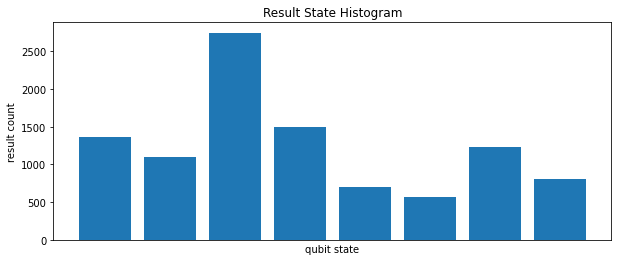

In [ ]:
ax = cirq.plot_state_histogram(results.histogram(key='out'))
ax.get_xaxis().set_ticks([])
plt.gcf().set_size_inches(10, 4)
plt.show(ax)

The leftmost and rightmost bars correspond to $|00..0\rangle$ and $|11..1\rangle$, respectively, which matches expectation for a GHZ state. Natural $|1\rangle → |0\rangle$ decay causes $|11..1\rangle$ to be much less common than $|00..0\rangle$, and other states also appear due to the various error mechanisms in the hardware that are mimicked by the simulated noise model. Learn more about these errors [here](https://arxiv.org/abs/2111.02396){:.external}.
